In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
plt.rc('font',family='serif')
import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pyemma.coordinates
import seaborn as sns

sns.set_style("white")
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob

In [3]:
fnames_phos = glob('/cbio/jclab/home/albaness/trajectories/AURKA/AURKA_phos_notpx2/*/run0-*.h5')
print(len(fnames_phos),fnames_phos[0])

50 /cbio/jclab/home/albaness/trajectories/AURKA/AURKA_phos_notpx2/11429/run0-clone0.h5


In [4]:
fnames_nophos = glob('/cbio/jclab/home/albaness/trajectories/AURKA/AURKA_nophos_notpx2/*/run0-*.h5')
print(len(fnames_nophos),fnames_nophos[0])

50 /cbio/jclab/home/albaness/trajectories/AURKA/AURKA_nophos_notpx2/11418/run0-clone0.h5


In [ ]:
from msmbuilder.featurizer import DihedralFeaturizer

# retrofitting the dihedral featurizer to keep track of which atoms correspond
# to which elements of the feature vector, so that we can interpret these later
class LabeledDihedralFeaturizer(DihedralFeaturizer):
    def partial_transform(self,traj):
        x = []
        self.labels = []
        self.atom_list = []
        
        for a in self.types:
            func = getattr(md, 'compute_%s' % a)
            atoms,y = func(traj)
            self.labels.append(a)
            if self.sincos:
                self.atom_list.append(np.vstack([atoms]*2))
                
                x.extend([np.sin(y), np.cos(y)])
            else:
                self.atom_list.append(atoms)
                
                x.append(y)

        self.atom_list = np.vstack(self.atom_list)
        return np.hstack(x)
    
dih_model = LabeledDihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])

In [ ]:
import pyemma.coordinates

In [6]:
features = pyemma.coordinates.featurizer(fnames_phos[0])

In [23]:
def FeaturizeAndClassify():
    Xs = []
    Ys = []

    feat = pyemma.coordinates.featurizer(fnames_phos[0])
    #feat.add_contacts()
    feat.add_chi1_torsions(cossin=True)
    feat.add_backbone_torsions(cossin=True)
    #feat.add_dihedrals(cossin=True)
    print(feat.dimension())
    
    for filename in fnames_nophos:
        state_string = ['No Phos']

        try:
            traj = md.load(filename)
            x = feat.transform(traj)
            Xs.append(x) #needed to use list(x) at one point to convert to numpy array later
            Ys.append(state_string*len(x))
        except:
            pass
    
    for filename in fnames_phos:
        state_string = ['Phos']

        try:
            traj = md.load(filename)
            x = feat.transform(traj)
            Xs.append(x) #needed to use list(x) at one point to convert to numpy array later
            Ys.append(state_string*len(x))
        except:
            pass
    
    print('These should be the same: %s,%s' %( len(Xs),len(fnames_nophos)+len(fnames_phos)))
        
    X = np.vstack(Xs)
    Y = np.hstack(Ys)
    
    print('These should have the same first dimension: %s,%s,%s'%(X.shape,Y.shape,len(set(Y))))
    
    #Before we can use decision tree we need to transform our categorical 
    # parameters ('DFG_in' and 'DFG_out') to numerical parameters
    
    le = preprocessing.LabelEncoder()
    le.fit(['No Phos','Phos'])
    print('These are our classes: %s' %list(le.classes_))
    Y = le.transform(Y)
    # le.inverse_transform(y) can be used to get back your original labels
    
    return [X,Y,le,feat]

In [24]:
[X,y,le,feat] = FeaturizeAndClassify()

1530
These should be the same: 100,100
These should have the same first dimension: (220000, 1530),(220000,),2
These are our classes: ['No Phos', 'Phos']


In [36]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt.fit(X[::50],y[::50])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [37]:
dt.score(X,y)

0.99998181818181819

In [38]:
dt.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

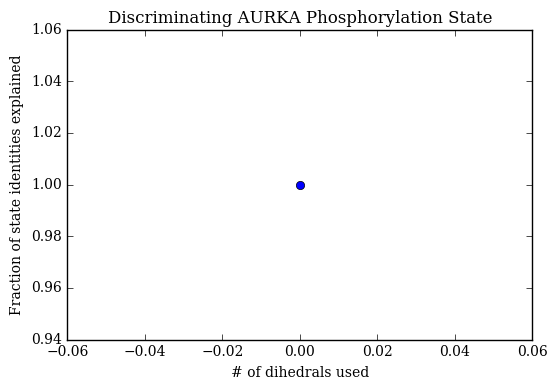

In [39]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(dt.feature_importances_[dt.feature_importances_!=0])[::-1])*dt.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of dihedrals used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating AURKA Phosphorylation State')

In [40]:
feature_importances = dt.feature_importances_[dt.feature_importances_!=0]
sorted_inds = np.array(sorted(np.arange(len(feature_importances)),key=lambda i:-feature_importances[i]))

In [41]:
sorted_inds

array([0])

In [42]:
features = feat.describe()

In [43]:
features[sorted_inds]

/cbio/jclab/home/albaness/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  """Entry point for launching an IPython kernel.


'COS(CHI1 0 SER 123 )'

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
clf = RandomForestClassifier(n_estimators=10,max_depth=None,
  min_samples_split=2, random_state=0)
clf = clf.fit(X,y)

In [7]:
from sklearn.model_selection import cross_val_score

In [48]:
scores = cross_val_score(clf, X, y)
scores

array([ 1.,  1.,  1.])

In [49]:
scores.mean()

1.0

In [50]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [51]:
clf.score(X,y)

1.0

In [52]:
clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

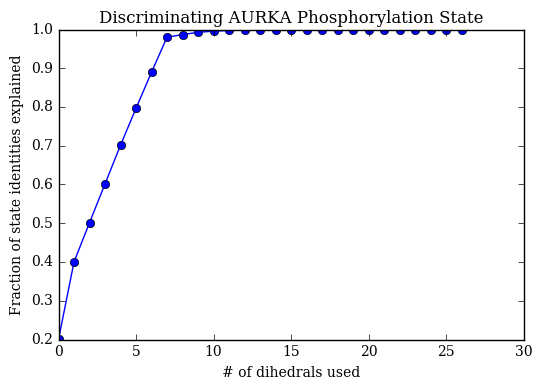

In [53]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(clf.feature_importances_[clf.feature_importances_!=0])[::-1])*clf.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of dihedrals used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating AURKA Phosphorylation State')

In [54]:
clf.feature_importances_[clf.feature_importances_!=0]

array([  1.64654807e-05,   5.37612668e-06,   1.82739528e-03,
         1.01328311e-01,   1.99992670e-01,   3.66557572e-06,
         9.54887444e-02,   1.11805383e-04,   2.00003665e-01,
         1.77268672e-06,   9.06028779e-02,   1.41057011e-04,
         3.80199844e-05,   5.97021861e-03,   1.00000000e-01,
         5.07596732e-05,   5.49976516e-06,   6.66041988e-03,
         7.19448167e-04,   9.05559064e-06,   1.83329658e-06,
         1.33177016e-03,   1.00000000e-01,   1.83275516e-06,
         3.65666025e-06,   2.99665850e-03,   9.26870215e-02])

In [60]:
len (clf.feature_importances_[clf.feature_importances_!=0])

27

In [61]:
# get indices
non_zero_indices = [i for i,x in enumerate(clf.feature_importances_!=0) if x]

In [62]:
non_zero_indices

[287,
 294,
 299,
 329,
 335,
 339,
 354,
 421,
 423,
 769,
 1144,
 1162,
 1163,
 1166,
 1168,
 1169,
 1173,
 1179,
 1224,
 1243,
 1249,
 1282,
 1288,
 1315,
 1428,
 1464,
 1487]

In [63]:
len(non_zero_indices)

27

In [64]:
# Let's get sorted non-zero-indices
sorted_importance = sorted(clf.feature_importances_[clf.feature_importances_!=0])

In [65]:
sorted_non_zero_indices = []
for value in sorted_importance:
    for i,x in enumerate(clf.feature_importances_):
        if x == value:
            sorted_non_zero_indices.append(i)
        else:
            pass

In [66]:
sorted_non_zero_indices

[769,
 1315,
 1249,
 1428,
 339,
 294,
 1173,
 1243,
 287,
 1163,
 1169,
 421,
 1162,
 1224,
 1282,
 299,
 1464,
 1166,
 1179,
 1144,
 1487,
 354,
 1168,
 1288,
 1168,
 1288,
 329,
 335,
 423]

In [68]:
for index in sorted_non_zero_indices:
    print(feat.describe()[index])
    print(clf.feature_importances_[index])

SIN(PSI 0 TYR 197)
1.77268671578e-06
SIN(PHI 0 GLN 335)
1.83275516118e-06
SIN(PSI 0 VAL 317)
1.8332965794e-06
COS(PSI 0 ARG 362)
3.65666025245e-06
SIN(CHI1 0 LEU 318 )
3.66557571802e-06
COS(CHI1 0 ASP 294 )
5.37612667788e-06
SIN(PSI 0 PRO 298)
5.49976515533e-06
SIN(PHI 0 VAL 317)
9.05559064009e-06
SIN(CHI1 0 LEU 289 )
1.6465480735e-05
SIN(PHI 0 PRO 297)
3.80199844317e-05
SIN(PSI 0 PRO 297)
5.07596732024e-05
SIN(CHI1 0 LEU 363 )
0.000111805383481
COS(PHI 0 PRO 297)
0.000141057010529
COS(PSI 0 ASP 311)
0.000719448167313
COS(PHI 0 PRO 327)
0.00133177015746
SIN(CHI1 0 LEU 296 )
0.00182739527709
COS(PSI 0 ARG 371)
0.00299665849635
COS(PHI 0 PRO 298)
0.00597021861498
SIN(PHI 0 ILE 301)
0.00666041988363
COS(PSI 0 GLY 291)
0.0906028778572
SIN(PHI 0 LEU 378)
0.0926870215056
COS(CHI1 0 PRO 327 )
0.0954887444142
COS(PSI 0 PRO 297)
0.1
COS(PSI 0 PRO 327)
0.1
COS(PSI 0 PRO 297)
0.1
COS(PSI 0 PRO 327)
0.1
SIN(CHI1 0 LEU 312 )
0.101328311213
SIN(CHI1 0 LEU 315 )
0.199992669659
SIN(CHI1 0 LEU 364 )
0.

In [3]:
X = np.load('/cbio/jclab/home/albaness/github/AURKA_UMN/scripts/contacts.npy')

In [4]:
y = np.load('/cbio/jclab/home/albaness/github/AURKA_UMN/scripts/run_labels.npy')

In [5]:
clf = RandomForestClassifier(n_estimators=10,max_depth=None,
  min_samples_split=2, random_state=0)
clf = clf.fit(X,y)

In [6]:
scores = cross_val_score(clf, X, y)
scores

array([ 0.74771593,  0.74358065,  0.72770785])

In [7]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [8]:
clf.score(X,y)

0.99086818181818181

In [9]:
clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

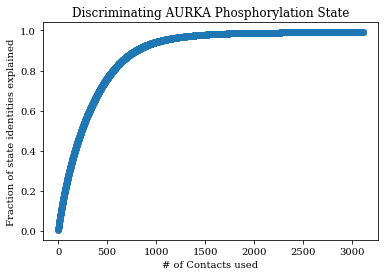

In [10]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(clf.feature_importances_[clf.feature_importances_!=0])[::-1])*clf.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of Contacts used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating AURKA Phosphorylation State')

In [11]:
len (clf.feature_importances_[clf.feature_importances_!=0])

3111

In [12]:
# get indices
non_zero_indices = [i for i,x in enumerate(clf.feature_importances_!=0) if x]

In [13]:
# Let's get sorted non-zero-indices
sorted_importance = sorted(clf.feature_importances_[clf.feature_importances_!=0])

In [14]:
sorted_non_zero_indices = []
for value in sorted_importance:
    for i,x in enumerate(clf.feature_importances_):
        if x == value:
            sorted_non_zero_indices.append(i)
        else:
            pass

In [15]:
for index in sorted_non_zero_indices[:100]:
    print(feat.describe()[index])
    print(clf.feature_importances_[index])

NameError: name 'feat' is not defined

In [19]:
feat = pyemma.coordinates.featurizer(fnames_phos[0])

In [20]:
feat.add_residue_mindist()

18-04-17 22:06:41 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


In [21]:
for index in sorted_non_zero_indices[:100]:
    print(feat.describe()[index])
    print(clf.feature_importances_[index])

RES_DIST (closest-heavy) VAL174 - ILE301
2.72084089853e-10
RES_DIST (closest-heavy) GLY145 - VAL352
3.39962302342e-10
RES_DIST (closest-heavy) GLU183 - LYS339
4.62165528076e-10
RES_DIST (closest-heavy) LYS171 - MET300
6.05016691302e-10
RES_DIST (closest-heavy) HIS176 - HIS380
7.16064971162e-10
RES_DIST (closest-heavy) GLU175 - VAL324
7.90812568673e-10
RES_DIST (closest-heavy) ILE184 - ARG340
9.67489307011e-10
RES_DIST (closest-heavy) LYS166 - VAL377
1.14829251934e-09
RES_DIST (closest-heavy) GLU175 - MET373
1.1936817378e-09
RES_DIST (closest-heavy) GLN127 - LEU312
1.34780568896e-09
RES_DIST (closest-heavy) GLU175 - VAL377
1.37711546149e-09
RES_DIST (closest-heavy) GLY173 - ILE301
2.0272243532e-09
RES_DIST (closest-heavy) PRO138 - GLN370
2.36424712957e-09
RES_DIST (closest-heavy) GLN177 - GLU336
2.50893918126e-09
RES_DIST (closest-heavy) LEU169 - VAL377
2.83302323447e-09
RES_DIST (closest-heavy) ALA167 - GLU302
2.95057950681e-09
RES_DIST (closest-heavy) LEU178 - THR347
2.95503815275e-09

In [5]:
X = np.load('/cbio/jclab/home/albaness/github/AURKA_UMN/scripts/distances.npy')

y = np.load('/cbio/jclab/home/albaness/github/AURKA_UMN/scripts/run_labels_dist.npy')

In [6]:
clf = RandomForestClassifier(n_estimators=10,max_depth=None,
  min_samples_split=2, random_state=0)
clf = clf.fit(X,y)

In [7]:
scores = cross_val_score(clf, X, y)
scores

array([ 1.,  1.,  1.])

In [8]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [9]:
clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [10]:
clf.score(X,y)

1.0

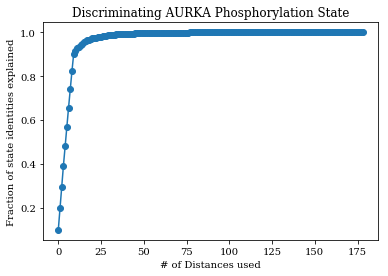

In [12]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(clf.feature_importances_[clf.feature_importances_!=0])[::-1])*clf.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of Distances used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating AURKA Phosphorylation State')

In [13]:
len (clf.feature_importances_[clf.feature_importances_!=0])

179

In [14]:
# get indices
non_zero_indices = [i for i,x in enumerate(clf.feature_importances_!=0) if x]

In [15]:
# Let's get sorted non-zero-indices
sorted_importance = sorted(clf.feature_importances_[clf.feature_importances_!=0])

In [16]:
sorted_non_zero_indices = []
for value in sorted_importance:
    for i,x in enumerate(clf.feature_importances_):
        if x == value:
            sorted_non_zero_indices.append(i)
        else:
            pass

In [17]:
feat = pyemma.coordinates.featurizer(fnames_phos[0])

In [19]:
feat.add_distances_ca()

In [20]:
for index in sorted_non_zero_indices[:10]:
    print(feat.describe()[index])
    print(clf.feature_importances_[index])

DIST: ARG 205 CA 1393 0 - VAL 352 CA 3791 0
1.31665200994e-08
DIST: GLU 239 CA 1977 0 - GLY 316 CA 3198 0
3.59113225985e-08
DIST: LEU 296 CA 2870 0 - GLU 354 CA 3821 0
5.08452852895e-08
DIST: ILE 193 CA 1190 0 - GLY 291 CA 2797 0
1.52677578822e-07
DIST: THR 353 CA 3807 0 - THR 384 CA 4332 0
1.37431426482e-06
DIST: HIS 280 CA 2620 0 - LYS 309 CA 3075 0
1.68008908218e-06
DIST: HIS 176 CA 891 0 - GLU 376 CA 4193 0
1.75408280722e-06
DIST: TYR 236 CA 1923 0 - TYR 246 CA 2075 0
1.76731437057e-06
DIST: ARG 126 CA 59 0 - VAL 206 CA 1417 0
1.77370108383e-06
DIST: LEU 240 CA 1992 0 - LEU 359 CA 3889 0
1.79474538476e-06


In [68]:
from sklearn.externals import joblib

In [69]:
clf = joblib.load('github/AURKA_UMN/scripts/randomforest_2000trees.pkl')

In [70]:
X = np.load('/cbio/jclab/home/albaness/github/AURKA_UMN/scripts/distances.npy') # shaped n_frames by n_distances
y = np.load('/cbio/jclab/home/albaness/github/AURKA_UMN/scripts/run_labels_dist.npy') # same shape, contains data labels

In [8]:
scores = cross_val_score(clf, X, y)

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.2min finished
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 354 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 704 tasks      | elapsed:    1.1s
[Parallel(n_jobs=48)]: Done 1154 tasks      | elapsed:    1.7s
[Parallel(n_jobs=48)]: Done 1704 tasks      | elapsed:    2.5s
[Parallel(n_jobs=48)]: Done 2000 out of 2000 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1154 tasks      

In [9]:
scores

array([ 1.,  1.,  1.])

[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:    0.6s
[Parallel(n_jobs=48)]: Done 354 tasks      | elapsed:    1.7s
[Parallel(n_jobs=48)]: Done 704 tasks      | elapsed:    3.3s
[Parallel(n_jobs=48)]: Done 1154 tasks      | elapsed:    5.4s
[Parallel(n_jobs=48)]: Done 1704 tasks      | elapsed:    7.9s
[Parallel(n_jobs=48)]: Done 2000 out of 2000 | elapsed:    9.2s finished


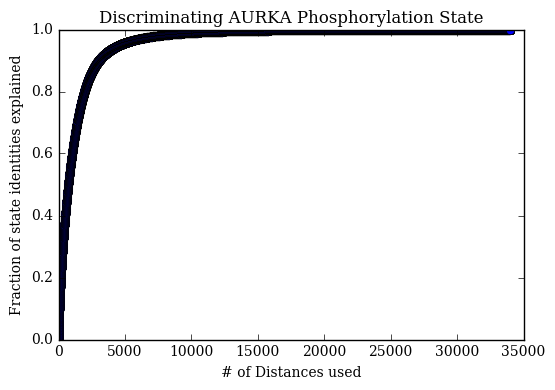

In [10]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(clf.feature_importances_[clf.feature_importances_!=0])[::-1])*clf.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of Distances used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating AURKA Phosphorylation State')

In [16]:
len (clf.feature_importances_[clf.feature_importances_!=0])

33992

In [71]:
non_zero_indices = [i for i,x in enumerate(clf.feature_importances_!=0) if x]

In [72]:
sorted_importance = sorted(clf.feature_importances_[clf.feature_importances_!=0])

In [76]:
sorted_non_zero_indices = []
for value in sorted_importance[:15]:
    for i,x in enumerate(clf.feature_importances_):
        if x == value:
            sorted_non_zero_indices.append(i)
        else:
            pass

In [74]:
feat = pyemma.coordinates.featurizer(fnames_phos[0])
feat.add_distances_ca()

In [77]:
for index in sorted_non_zero_indices:
    print(feat.describe()[index])
    print(clf.feature_importances_[index])

DIST: ALA 243 CA 2035 0 - PRO 259 CA 2309 0
4.50714747603e-12
DIST: PRO 328 CA 3384 0 - ARG 362 CA 3938 0
1.06937788074e-11
DIST: LEU 188 CA 1102 0 - SER 342 CA 3625 0
1.08167386186e-11
DIST: PRO 191 CA 1161 0 - ILE 301 CA 2949 0
1.14869504846e-11
DIST: GLN 223 CA 1706 0 - SER 266 CA 2417 0
1.29069246603e-11
DIST: TYR 212 CA 1526 0 - TPO 288 CA 2749 0
1.60919175681e-11
DIST: GLY 142 CA 327 0 - PHE 200 CA 1320 0
1.70695950209e-11
DIST: LYS 141 CA 305 0 - HIS 254 CA 2216 0
2.02771035812e-11
DIST: ALA 150 CA 453 0 - ALA 160 CA 632 0
2.15358268813e-11
DIST: ARG 137 CA 241 0 - GLN 154 CA 524 0
2.39635585089e-11
DIST: THR 233 CA 1885 0 - THR 238 CA 1963 0
2.64601946588e-11
DIST: ALA 203 CA 1369 0 - ARG 343 CA 3636 0
2.70113373169e-11
DIST: SER 123 CA 4 0 - TYR 236 CA 1923 0
2.73813255469e-11
DIST: TYR 236 CA 1923 0 - GLU 269 CA 2445 0
2.78286774715e-11
DIST: SER 155 CA 541 0 - GLN 223 CA 1706 0
2.94841563287e-11


In [5]:
phos_data = glob('/cbio/jclab/home/albaness/github/AURKA_UMN/data/probe_analysis/distances_AURKA_AURKA_phos_notpx2-*.npy')

In [7]:
nophos_data = glob('/cbio/jclab/home/albaness/github/AURKA_UMN/data/probe_analysis/distances_AURKA_AURKA_nophos_notpx2-*.npy')

In [8]:
data_phos = np.load(phos_data[0])
data_nophos = np.load(nophos_data[0])
fnames_phos = glob('/cbio/jclab/home/albaness/trajectories/AURKA/AURKA_phos_notpx2/*/run0-*.h5')

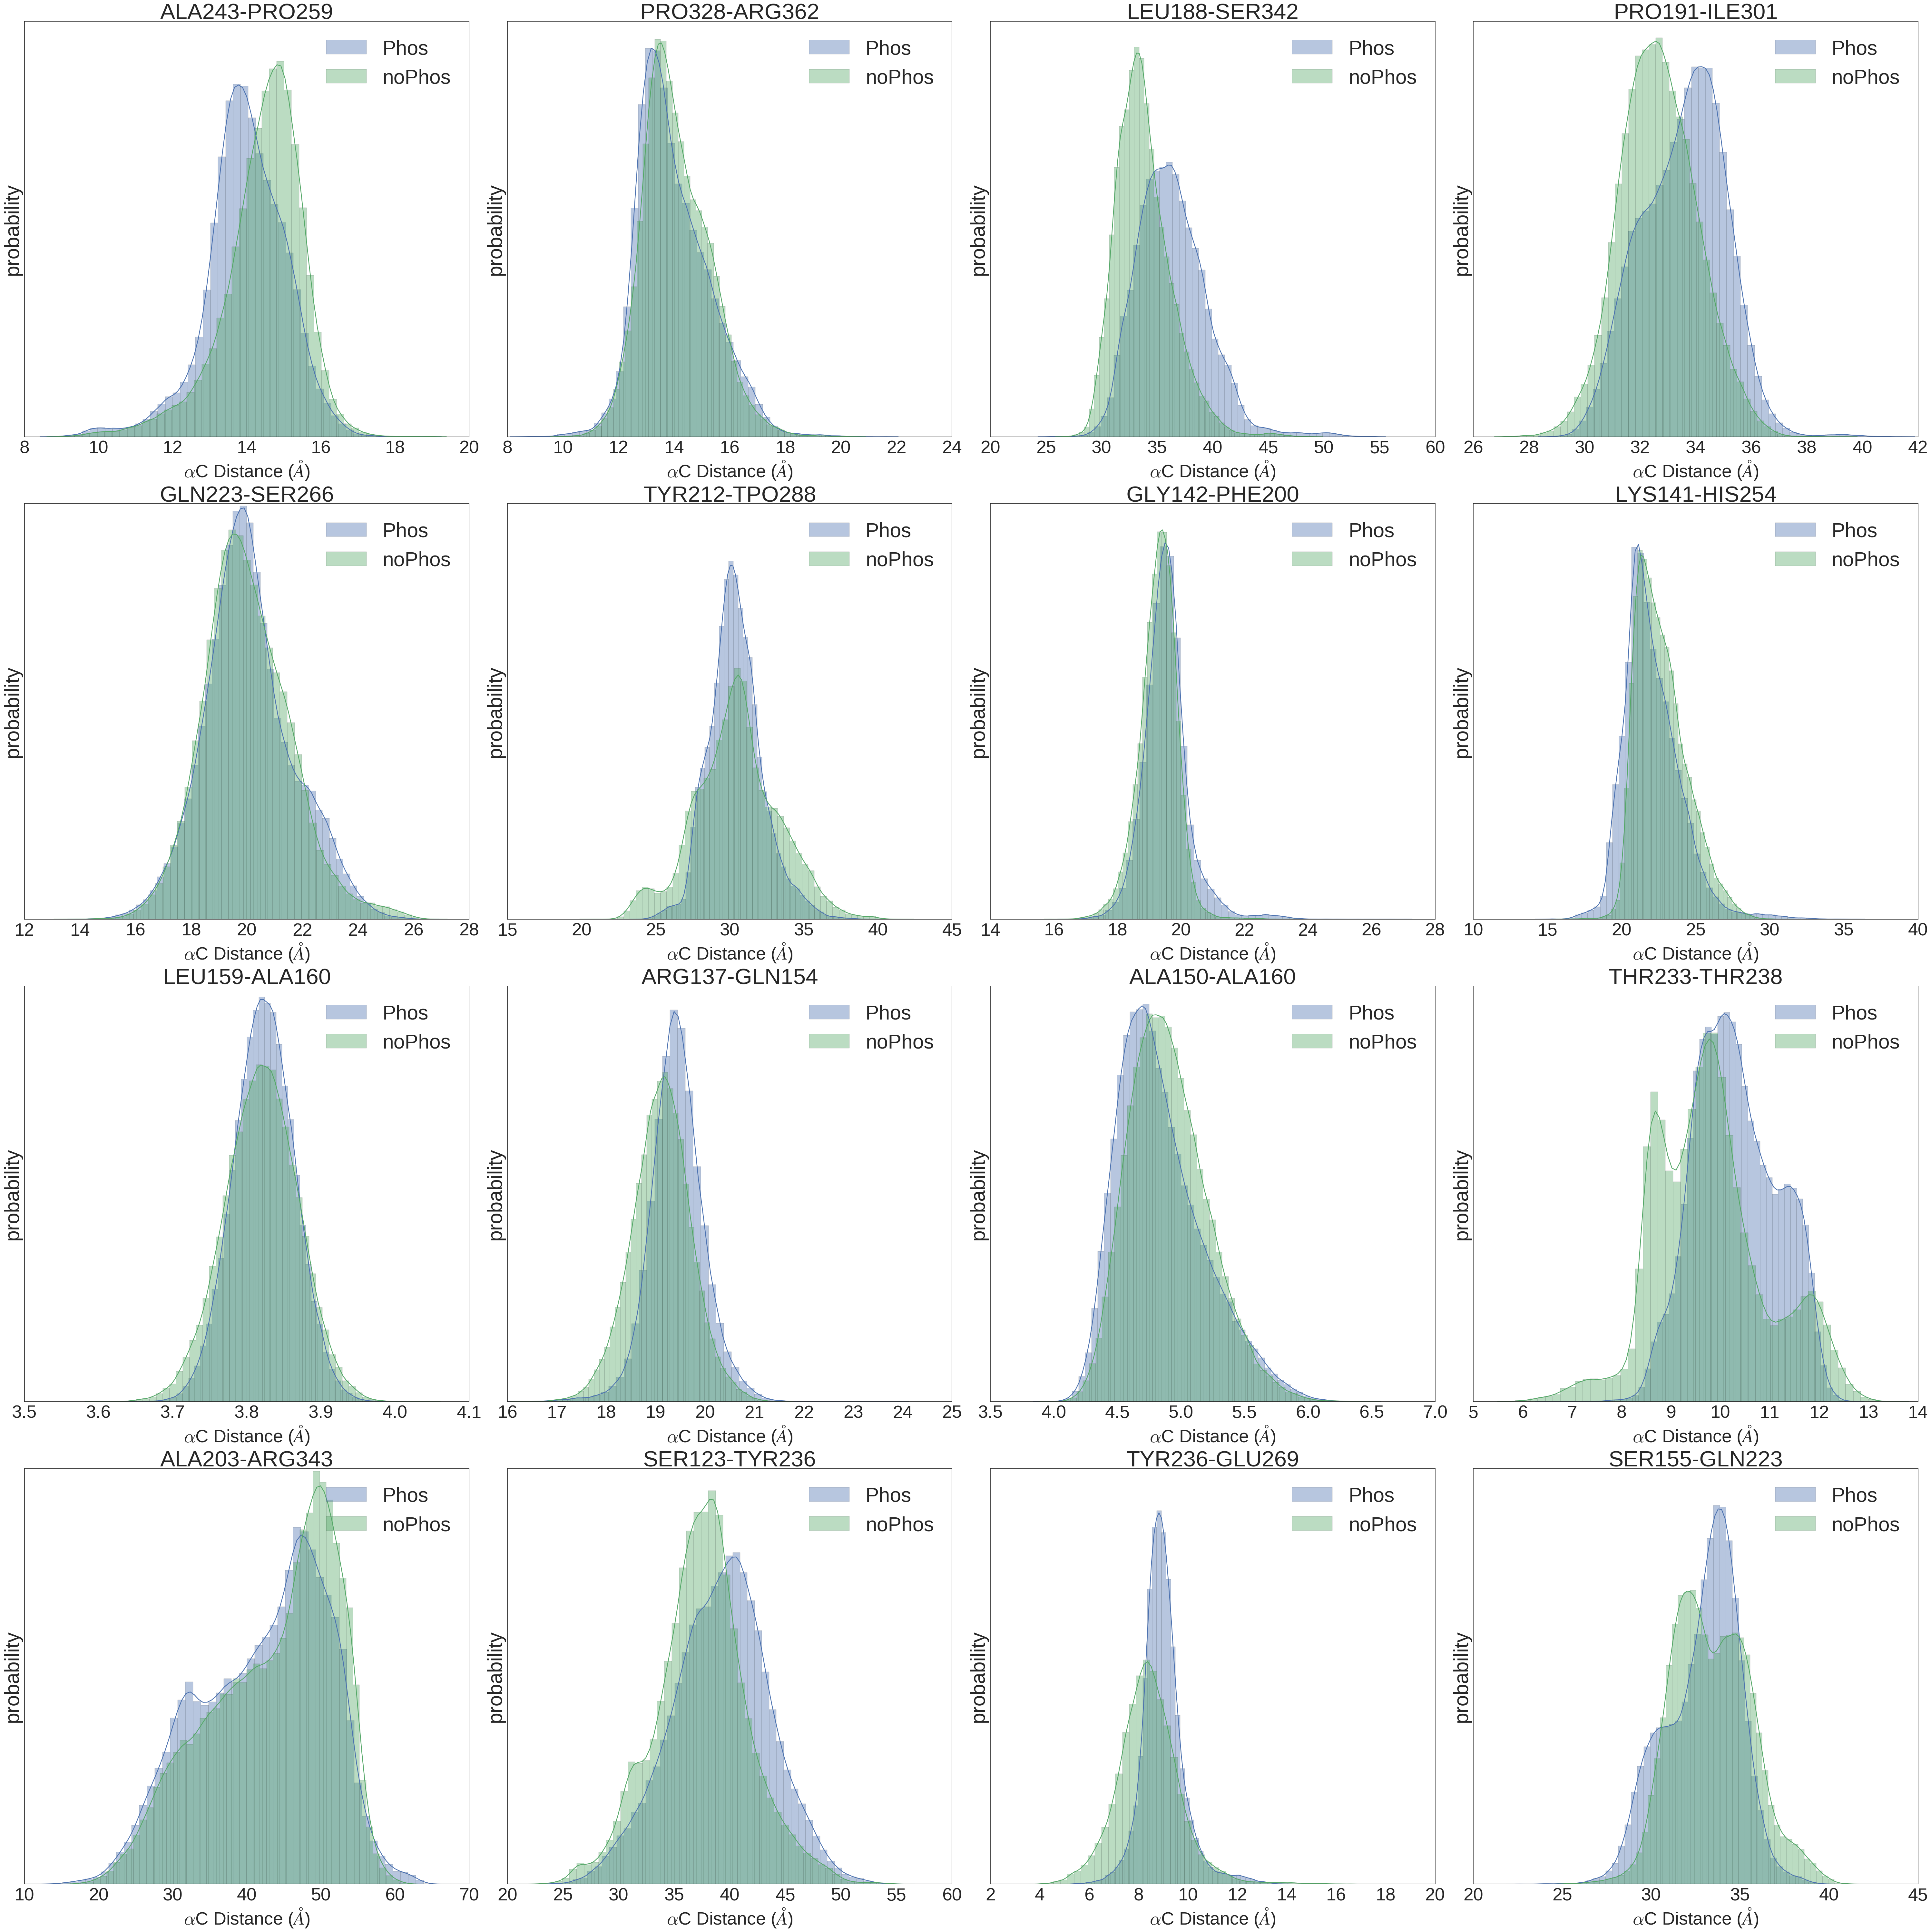

In [14]:
plt.figure(figsize=(60,60), dpi=300)
t = md.load(fnames_phos[0])
for i,name in enumerate(phos_data):
    ind=i+1
    plt.subplot(4,4,ind)
    labels = []
    data_phos = np.load(phos_data[i])
    data_nophos = np.load(nophos_data[i])
    name = phos_data[i][97:-4]
    res1_index = name[4:7]
    res2_index = name[8:11]
    res1_name = t.topology.residue(int(res1_index)-123)
    res2_name = t.topology.residue(int(res2_index)-123)
    sns.distplot(data_phos,bins=None, norm_hist=True)
    labels.append('Phos')
    sns.distplot(data_nophos,bins=None, norm_hist=True)
    labels.append('noPhos')
    plt.title('%s-%s' % (res1_name, res2_name), fontsize=50)
    plt.legend(labels, fontsize=45);
    plt.xlabel('$\\alpha$C Distance ($\\AA$)', fontsize=40);
    plt.ylabel('probability', fontsize=45)
    plt.yticks([], fontsize=30);
    plt.xticks(fontsize=40)
    plt.tight_layout()
    #plt.show()
plt.savefig('ac-dist.pdf')